# PANDA EfficientNet-B0 Baseline with 36 x tiles_256

Hi everyone,

I'm here to show you how to train a single efficientnet-b0 model to get LB 0.87

Inference kernel is https://www.kaggle.com/haqishen/panda-inference-w-36-tiles-256

If you find find any of the following idea helps, please upvote me, THANKS!

# Summary of This Baseline

* Using tiling method based on https://www.kaggle.com/iafoss/panda-16x128x128-tiles
    * Simply setting the `N = 36` and `sz=256` then extract from median resolution
* Create 6x6 big image from 36 tiles
* Efficientnet-B0
* Binning label
    * E.g.
        * `label = [0,0,0,0,0]` means `isup_grade = 0`
        * `label = [1,1,1,0,0]` means `isup_grade = 3`
        * `label = [1,1,1,1,1]` means `isup_grade = 5`
* BCE loss
* Augmentation on both tile level and big image level
* CosineAnnealingLR for one round

# MEMO

The full training process need over `10h` to run so you should run it on your own machine.

# Update
* Version 1
    * Baseline
* Version 2, 3
    * Add some Markdown Text
* Version 4
    * Fix `init_lr` from 3e-5 to 3e-4
* Version 5
    * Add warmup scheduler
    * Add training log for this version
* Version 6
    * Fix the bug that train from scratch. Now it's train from ImageNet pretrained weights. Actually I haven't tried train from scratch yet.
* Version 7, 8
    * Update accuracy calculate.
    * Fix tiny bug.

In [29]:
DEBUG = False

In [3]:
!pip install git+https://github.com/ildoonet/pytorch-gradual-warmup-lr.git

  Cloning https://github.com/ildoonet/pytorch-gradual-warmup-lr.git to /tmp/pip-req-build-p77lfqpz
  Running command git clone -q https://github.com/ildoonet/pytorch-gradual-warmup-lr.git /tmp/pip-req-build-p77lfqpz
  Created wheel for warmup-scheduler: filename=warmup_scheduler-0.3.2-py3-none-any.whl size=3881 sha256=230f41c42a1f576761f9f1692048b8ad7244400aebe0edf96ccca35dbbf535f8
  Stored in directory: /tmp/pip-ephem-wheel-cache-acaouf86/wheels/bf/81/52/0e3bc0b645a339f94c76b4dcb8c8b7a5f588a614f5add83b9f
Successfully built warmup-scheduler


In [4]:
import os
import sys
#sys.path = ['../input/efficientnet-pytorch/EfficientNet-PyTorch/EfficientNet-PyTorch-master',] + sys.path

In [6]:
import time
import skimage.io
import numpy as np
import pandas as pd
import cv2
import PIL.Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler, RandomSampler, SequentialSampler
from warmup_scheduler import GradualWarmupScheduler
from efficientnet_pytorch import model as enet, EfficientNet
import albumentations
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from sklearn.metrics import cohen_kappa_score
from tqdm import tqdm_notebook as tqdm



In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Config

In [10]:
tiles_folder = '../data/tiles_data/train'

In [11]:
image_ids = {filepath[:32] for filepath in os.listdir(tiles_folder)}

In [30]:
#data_dir = '../input/prostate-cancer-grade-assessment'
df_train = pd.read_csv('../data/train.csv').set_index('image_id')
#image_folder = os.path.join(data_dir, 'train_images')

fold = 0
tile_size = 128
image_size = 128
n_tiles = 16
batch_size = 4
num_workers = 4
out_dim = 5
init_lr = 3e-4
warmup_factor = 10

warmup_epo = 1
n_epochs = 2 if DEBUG else 30
df_train = df_train.loc[image_ids].reset_index()
df_train = df_train.sample(100).reset_index(drop=True) if DEBUG else df_train

In [31]:
df_train.head()

,image_id,data_provider,isup_grade,gleason_score
0,9fa42d765e1d7d376d4fddc4c590ab37,radboud,5,4+5
1,99c79f407e7506bd87425fd24b8c9ec3,karolinska,3,4+3
2,aed7330d040f019f279d673133cbfe53,radboud,5,4+5
3,c5a4e4c6224fc6ac14e3e777a04258c1,radboud,1,3+3
4,97bf4d65f07954809658e01478408637,radboud,4,4+4


# Create Folds

In [32]:
skf = StratifiedKFold(5, shuffle=True, random_state=3)
df_train['fold'] = -1
for i, (train_idx, valid_idx) in enumerate(skf.split(df_train, df_train['isup_grade'])):
    df_train.loc[valid_idx, 'fold'] = i
df_train.head()

,image_id,data_provider,isup_grade,gleason_score,fold
0,9fa42d765e1d7d376d4fddc4c590ab37,radboud,5,4+5,2
1,99c79f407e7506bd87425fd24b8c9ec3,karolinska,3,4+3,1
2,aed7330d040f019f279d673133cbfe53,radboud,5,4+5,2
3,c5a4e4c6224fc6ac14e3e777a04258c1,radboud,1,3+3,2
4,97bf4d65f07954809658e01478408637,radboud,4,4+4,0


# Model

In [15]:
#pretrained_model = {'efficientnet-b0': '../input/efficientnet-pytorch/efficientnet-b0-08094119.pth'}

In [16]:
class enetv2(nn.Module):
    def __init__(self, out_dim):
        super(enetv2, self).__init__()
        #self.enet = enet.EfficientNet.from_name(backbone)
        #self.enet.load_state_dict(torch.load(pretrained_model[backbone]))
        self.enet = EfficientNet.from_pretrained('efficientnet-b0') 
        self.myfc = nn.Linear(self.enet._fc.in_features, out_dim)
        self.enet._fc = nn.Identity()

    def extract(self, x):
        return self.enet(x)

    def forward(self, x):
        x = self.extract(x)
        x = self.myfc(x)
        return x

# Dataset

In [17]:
class PANDADataset(Dataset):
    def __init__(self,
                 df,
                 image_size,
                 n_tiles=n_tiles,
                 tile_mode=0,
                 rand=False,
                 transform=None,
                ):

        self.df = df.reset_index(drop=True)
        self.image_size = image_size
        self.n_tiles = n_tiles
        self.tile_mode = tile_mode
        self.rand = rand
        self.transform = transform

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, index):
        row = self.df.iloc[index]
        img_id = row.image_id
        
        #tiff_file = os.path.join(image_folder, f'{img_id}.tiff')
        #image = skimage.io.MultiImage(tiff_file)[1]
        #tiles, OK = get_tiles(image, self.tile_mode)
        imgs = []
        for i in range(self.n_tiles):
            img = skimage.io.imread(os.path.join(tiles_folder,img_id+f"_{i}.png"))
            imgs.append(img)
        # Final shape is x:  n_tiles x 128 x 128 x 3
        imgs = np.array(imgs)
        #print(imgs.shape)
        if self.rand:
            idxes = np.random.choice(list(range(self.n_tiles)), self.n_tiles, replace=False)
        else:
            idxes = list(range(self.n_tiles))

        n_row_tiles = int(np.sqrt(self.n_tiles))
        mosaic = np.zeros((image_size * n_row_tiles, image_size * n_row_tiles, 3))
        for h in range(n_row_tiles):
            for w in range(n_row_tiles):
                i = h * n_row_tiles + w
    
                if len(imgs) > idxes[i]:
                    this_img = imgs[idxes[i]]
                else:
                    this_img = np.ones((self.image_size, self.image_size, 3)).astype(np.uint8) * 255
                this_img = 255 - this_img
                if self.transform is not None:
                    this_img = self.transform(image=this_img)['image']
                h1 = h * image_size
                w1 = w * image_size
                mosaic[h1:h1+image_size, w1:w1+image_size] = this_img

        if self.transform is not None:
            mosaic = self.transform(image=mosaic)['image']
        mosaic = mosaic.astype(np.float32)
        mosaic /= 255
        mosaic = mosaic.transpose(2, 0, 1)  # shape: 3 x (n_row_tiles*tile_size) x (n_row_tiles*tile_size)

        label = np.zeros(5).astype(np.float32)
        label[:row.isup_grade] = 1.
        return torch.tensor(mosaic), torch.tensor(label)


# Augmentations

In [19]:
transforms_train = albumentations.Compose([
    albumentations.Transpose(p=0.5),
    albumentations.VerticalFlip(p=0.5),
    albumentations.HorizontalFlip(p=0.5),
    #albumentations.augmentations.transforms.Rotate(limit=20,p=0.5)
])
transforms_val = albumentations.Compose([])

In [33]:
train_ds = PANDADataset(df_train, image_size, n_tiles, 0, rand=False, transform=transforms_train)

In [34]:
img, label = train_ds[0]

In [35]:
img.shape

torch.Size([3, 512, 512])

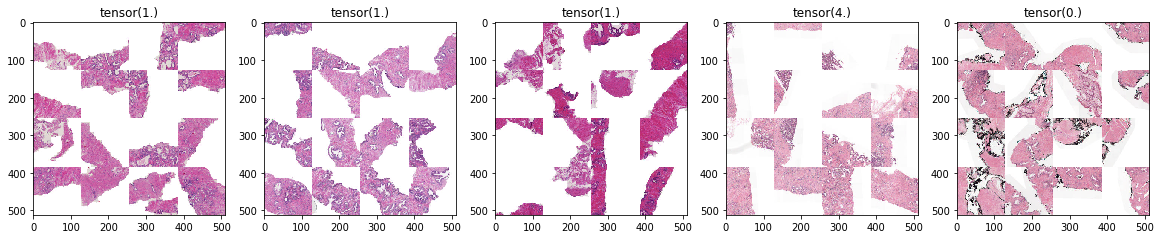

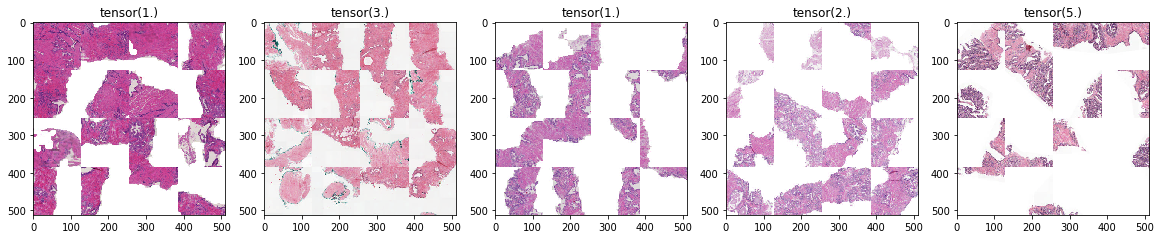

In [36]:
dataset_show = PANDADataset(df_train, image_size, n_tiles, 0, rand=False, transform=transforms_train)
from pylab import rcParams
rcParams['figure.figsize'] = 20,10
for i in range(2):
    f, axarr = plt.subplots(1,5)
    for p in range(5):
        idx = np.random.randint(0, len(dataset_show))
        img, label = dataset_show[idx]
        axarr[p].imshow(1-img.transpose(0, 1).transpose(1,2).squeeze())
        axarr[p].set_title(str(sum(label)))


# Loss

In [37]:
criterion = nn.BCEWithLogitsLoss()

# Train & Val

In [38]:
def train_epoch(loader, optimizer):

    model.train()
    train_loss = []
    bar = tqdm(loader)
    for (data, target) in bar:
        
        data, target = data.to(device), target.to(device)
        loss_func = criterion
        optimizer.zero_grad()
        logits = model(data)
        loss = loss_func(logits, target)
        loss.backward()
        optimizer.step()

        loss_np = loss.detach().cpu().numpy()
        train_loss.append(loss_np)
        smooth_loss = sum(train_loss[-100:]) / min(len(train_loss), 100)
        bar.set_description('loss: %.5f, smth: %.5f' % (loss_np, smooth_loss))
    return train_loss


def val_epoch(loader, get_output=False):

    model.eval()
    val_loss = []
    LOGITS = []
    PREDS = []
    TARGETS = []

    with torch.no_grad():
        for (data, target) in tqdm(loader):
            data, target = data.to(device), target.to(device)
            logits = model(data)

            loss = criterion(logits, target)

            pred = logits.sigmoid().sum(1).detach().round()
            LOGITS.append(logits)
            PREDS.append(pred)
            TARGETS.append(target.sum(1))

            val_loss.append(loss.detach().cpu().numpy())
        val_loss = np.mean(val_loss)

    LOGITS = torch.cat(LOGITS).cpu().numpy()
    PREDS = torch.cat(PREDS).cpu().numpy()
    TARGETS = torch.cat(TARGETS).cpu().numpy()
    acc = (PREDS == TARGETS).mean() * 100.
    
    qwk = cohen_kappa_score(PREDS, TARGETS, weights='quadratic')
    qwk_k = cohen_kappa_score(PREDS[df_valid['data_provider'] == 'karolinska'], df_valid[df_valid['data_provider'] == 'karolinska'].isup_grade.values, weights='quadratic')
    qwk_r = cohen_kappa_score(PREDS[df_valid['data_provider'] == 'radboud'], df_valid[df_valid['data_provider'] == 'radboud'].isup_grade.values, weights='quadratic')
    print('qwk', qwk, 'qwk_k', qwk_k, 'qwk_r', qwk_r)

    if get_output:
        return LOGITS
    else:
        return val_loss, acc, qwk

    

# Create Dataloader & Model & Optimizer

In [39]:
train_idx = np.where((df_train['fold'] != fold))[0]
valid_idx = np.where((df_train['fold'] == fold))[0]

df_this  = df_train.loc[train_idx]
df_valid = df_train.loc[valid_idx]

dataset_train = PANDADataset(df_this , image_size, n_tiles, transform=transforms_train)
dataset_valid = PANDADataset(df_valid, image_size, n_tiles, transform=transforms_val)

train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, sampler=RandomSampler(dataset_train), num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, sampler=SequentialSampler(dataset_valid), num_workers=num_workers)

model = enetv2(out_dim=out_dim)
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=init_lr/warmup_factor)
scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, n_epochs-warmup_epo)
scheduler = GradualWarmupScheduler(optimizer, multiplier=warmup_factor, total_epoch=warmup_epo, after_scheduler=scheduler_cosine)

print(len(dataset_train), len(dataset_valid))

Loaded pretrained weights for efficientnet-b0
8412 2104


# Run Training

In [40]:
qwk_max = 0.
best_file = f'../models/efficientnet_best_fold{fold}.pth'
for epoch in range(1, n_epochs+1):
    print(time.ctime(), 'Epoch:', epoch)
    scheduler.step(epoch-1)
    print(f'lr: {optimizer.param_groups[0]["lr"]:.7f}')

    train_loss = train_epoch(train_loader, optimizer)
    val_loss, acc, qwk = val_epoch(valid_loader)

    content = time.ctime() + ' ' + f'Epoch {epoch}, lr: {optimizer.param_groups[0]["lr"]:.7f}, train loss: {np.mean(train_loss):.5f}, val loss: {np.mean(val_loss):.5f}, acc: {(acc):.5f}, qwk: {(qwk):.5f}'
    print(content)
    with open(f'../logs/log_efficientnet.txt', 'a') as appender:
        appender.write(content + '\n')

    if qwk > qwk_max:
        print('score2 ({:.6f} --> {:.6f}).  Saving model ...'.format(qwk_max, qwk))
        torch.save(model.state_dict(), f'../models/efficientnet_best_{qwk:.3f}_qwk_fold{fold}.pth')
        qwk_max = qwk

torch.save(model.state_dict(), os.path.join(f'efficientnet_final_fold{fold}.pth'))



Sun Jun 21 00:27:12 2020 Epoch: 1


/home/ubuntu/anaconda3/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/home/ubuntu/anaconda3/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate yo

/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



qwk 0.6822420997811436 qwk_k 0.6500681800999506 qwk_r 0.6082933473638665
Sun Jun 21 00:38:56 2020 Epoch 1, lr: 0.0000300, train loss: 0.45935, val loss: 0.36155, acc: 36.02662, qwk: 0.68224
score2 (0.000000 --> 0.682242).  Saving model ...
Sun Jun 21 00:38:56 2020 Epoch: 2



qwk 0.7094109686498182 qwk_k 0.6794749553790231 qwk_r 0.6484572889363045
Sun Jun 21 00:50:41 2020 Epoch 2, lr: 0.0003000, train loss: 0.42229, val loss: 0.36836, acc: 44.20152, qwk: 0.70941
score2 (0.682242 --> 0.709411).  Saving model ...
Sun Jun 21 00:50:41 2020 Epoch: 3



qwk 0.7570769908567956 qwk_k 0.742325353522048 qwk_r 0.6922842108052172
Sun Jun 21 01:02:26 2020 Epoch 3, lr: 0.0000300, train loss: 0.35479, val loss: 0.31466, acc: 46.15019, qwk: 0.75708
score2 (0.709411 --> 0.757077).  Saving model ...
Sun Jun 21 01:02:26 2020 Epoch: 4



qwk 0.7373345558761122 qwk_k 0.7300549376301798 qwk_r 0.6677398334016329
Sun Jun 21 01:14:10 2020 Epoch 4, lr: 0.0002965, train loss: 0.36917, val loss: 0.32184, acc: 43.20342, qwk: 0.73733
Sun Jun 21 01:14:10 2020 Epoch: 5



qwk 0.6592361604054351 qwk_k 0.6174868991881792 qwk_r 0.6299291087806207
Sun Jun 21 01:25:55 2020 Epoch 5, lr: 0.0002921, train loss: 0.34353, val loss: 0.34833, acc: 30.51331, qwk: 0.65924
Sun Jun 21 01:25:55 2020 Epoch: 6



qwk 0.7508349847991134 qwk_k 0.7442139995512349 qwk_r 0.6903266074334012
Sun Jun 21 01:37:41 2020 Epoch 6, lr: 0.0002861, train loss: 0.32790, val loss: 0.31345, acc: 48.43156, qwk: 0.75083
Sun Jun 21 01:37:41 2020 Epoch: 7



qwk 0.7693864830790589 qwk_k 0.7549686181789969 qwk_r 0.7231723599562832
Sun Jun 21 01:49:27 2020 Epoch 7, lr: 0.0002785, train loss: 0.31886, val loss: 0.30331, acc: 52.23384, qwk: 0.76939
score2 (0.757077 --> 0.769386).  Saving model ...
Sun Jun 21 01:49:27 2020 Epoch: 8



qwk 0.748100510817129 qwk_k 0.7340663937931036 qwk_r 0.6805634722739254
Sun Jun 21 02:01:13 2020 Epoch 8, lr: 0.0002694, train loss: 0.30544, val loss: 0.33413, acc: 48.81179, qwk: 0.74810
Sun Jun 21 02:01:13 2020 Epoch: 9



qwk 0.7625429175071572 qwk_k 0.7441156345888067 qwk_r 0.7197551280577721
Sun Jun 21 02:12:56 2020 Epoch 9, lr: 0.0002589, train loss: 0.29498, val loss: 0.31098, acc: 50.66540, qwk: 0.76254
Sun Jun 21 02:12:56 2020 Epoch: 10



qwk 0.7823010712211274 qwk_k 0.7590301084421076 qwk_r 0.7380969550084159
Sun Jun 21 02:24:42 2020 Epoch 10, lr: 0.0002471, train loss: 0.28656, val loss: 0.30238, acc: 51.71103, qwk: 0.78230
score2 (0.769386 --> 0.782301).  Saving model ...
Sun Jun 21 02:24:42 2020 Epoch: 11



qwk 0.7852301202827812 qwk_k 0.7686525522987396 qwk_r 0.7389498332910757
Sun Jun 21 02:36:27 2020 Epoch 11, lr: 0.0002342, train loss: 0.27624, val loss: 0.31088, acc: 52.32890, qwk: 0.78523
score2 (0.782301 --> 0.785230).  Saving model ...
Sun Jun 21 02:36:27 2020 Epoch: 12



qwk 0.7495681797266034 qwk_k 0.7454391061623467 qwk_r 0.6949153826728371
Sun Jun 21 02:48:13 2020 Epoch 12, lr: 0.0002203, train loss: 0.26542, val loss: 0.36205, acc: 50.95057, qwk: 0.74957
Sun Jun 21 02:48:13 2020 Epoch: 13



qwk 0.7756893554969481 qwk_k 0.7490149238348862 qwk_r 0.7414969330898534
Sun Jun 21 02:59:57 2020 Epoch 13, lr: 0.0002055, train loss: 0.26063, val loss: 0.36150, acc: 50.23764, qwk: 0.77569
Sun Jun 21 02:59:57 2020 Epoch: 14



qwk 0.779430657780595 qwk_k 0.7701682521107273 qwk_r 0.737863511075583
Sun Jun 21 03:11:42 2020 Epoch 14, lr: 0.0001901, train loss: 0.24983, val loss: 0.30832, acc: 53.75475, qwk: 0.77943
Sun Jun 21 03:11:42 2020 Epoch: 15



qwk 0.783190330895125 qwk_k 0.7794989959883091 qwk_r 0.7311139677412457
Sun Jun 21 03:23:28 2020 Epoch 15, lr: 0.0001743, train loss: 0.24057, val loss: 0.33074, acc: 53.51711, qwk: 0.78319
Sun Jun 21 03:23:28 2020 Epoch: 16



qwk 0.7790042603815708 qwk_k 0.7764361370610557 qwk_r 0.7251193485621095
Sun Jun 21 03:35:15 2020 Epoch 16, lr: 0.0001581, train loss: 0.23130, val loss: 0.34426, acc: 54.46768, qwk: 0.77900
Sun Jun 21 03:35:15 2020 Epoch: 17



qwk 0.7676888977782494 qwk_k 0.7396437369640338 qwk_r 0.7328944888955615
Sun Jun 21 03:46:59 2020 Epoch 17, lr: 0.0001419, train loss: 0.22120, val loss: 0.32879, acc: 52.23384, qwk: 0.76769
Sun Jun 21 03:46:59 2020 Epoch: 18



qwk 0.7871330465496156 qwk_k 0.7504272733995654 qwk_r 0.7681992515197642
Sun Jun 21 03:58:45 2020 Epoch 18, lr: 0.0001257, train loss: 0.21603, val loss: 0.30263, acc: 54.84791, qwk: 0.78713
score2 (0.785230 --> 0.787133).  Saving model ...
Sun Jun 21 03:58:45 2020 Epoch: 19


KeyboardInterrupt: 